In [84]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator ## add nice annotation ans statistical testing on plot
import statannotations as sta
import scipy.stats as ss ## stat functions from scipy
import scikit_posthocs as sp  ## stat functions from scikit

import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [4]:
def extract_data(path, adata):
    loom = sc.read( path, validate=False)
    tmp = pd.DataFrame(loom.X.toarray())
    tmp.columns = loom.var_names.to_list()
    tmp.index = loom.obs_names.to_list()
    adata = sc.read(adata)
    adata = adata[adata.obs.new_label != "Others"]
    labels = pd.Series(adata.obs.new_label)

    exh = pd.DataFrame(columns=tmp.columns)
    res = pd.DataFrame(columns=tmp.columns)

    for i,c in labels.items():
        if c == "NK exhausted":
            try:
                exh = exh.append(pd.DataFrame(tmp.loc[i]).T)
            except:
                pass
        elif c == "NK resident":
            try:
                res = res.append(pd.DataFrame(tmp.loc[i]).T)
            except:
                pass
        else:
            continue
    return exh, res


In [5]:
ht_exh, ht_res = extract_data("Results/75/ht_scenic_integrated-output.loom", "Data/75/heathy_nk_processed.h5ad")
mm_exh, mm_res = extract_data("Results/75/mm_scenic_integrated-output.loom", "Data/75/mm_nk_processed.h5ad")

In [6]:
# ht_res = extract_data("Results/ht_res_scenic_integrated-output.loom")
# ht_exh = extract_data("Results/ht_exh_scenic_integrated-output.loom")
# mm_res = extract_data("Results/mm_res_scenic_integrated-output.loom")
# mm_exh = extract_data("Results/mm_exh_scenic_integrated-output.loom")

dfs = {"ht_res": ht_res, "ht_exh":ht_exh,"mm_res":mm_res,"mm_exh":mm_exh}

In [7]:

def plot_mean_auc(TF):
    means = {}

    for k,v in dfs.items():
        try:
            means[k] = v[TF].mean()
        except:
            #print(f"{TF} missing in {k}")
            pass
    
    means_df = pd.DataFrame(means, index=[0])
    try:
        means_df.plot.bar()
        plt.title(TF + " avg activity")
    except:
        pass
    
def get_values(df, TF):
    tmp = pd.DataFrame(dfs[df][TF])
    tmp = tmp[TF].values
    tmp = tmp[tmp!=0]
    return tmp



def stat(df1, df2, TF):
    pair = (df1,df2)
    try:
        value1 = get_values(df1, TF)
        value2 = get_values(df2, TF)
    except:
        d = {'TF': [TF], df1: "missing value", df2: "",'p-value':"", 'test': ""}
        df = pd.DataFrame.from_dict(data=d, orient="columns")
        return df

    
         
    if ((ss.normaltest(value1)[1] > 0.05 and ss.normaltest(value2)[1] > 0.05) and (ss.bartlett(value2,value1)[1] > 0.05)):
        test = 't-test_ind'
        pvalue = ss.ttest_ind(value1, value2, nan_policy="omit", equal_var=True).pvalue 
        



    elif ((ss.normaltest(value1)[1] > 0.05 and ss.normaltest(value2)[1] > 0.05) and (ss.bartlett(value2,value1)[1] < 0.05)):
        test = 't-test_welch'
        pvalue = ss.ttest_ind(value1, value2, nan_policy="omit", equal_var=False).pvalue 
        


    else:
        test = 'Kruskal-Wallis'
        pvalue = ss.kruskal(value1, value2, nan_policy="omit").pvalue 


        
    if pvalue <= 1.00e-04:
        stars = '****'
    elif pvalue > 1.00e-04 and pvalue <= 1.00e-03:
        stars = '***'
    elif pvalue > 1.00e-03 and pvalue <= 1.00e-02:
        stars = '**'
    elif pvalue > 1.00e-02 and pvalue <= 5.00e-02:
        stars = '*'
    else:
        stars = 'np'
    d = {'TF': [TF], df1: [np.mean(value1)], df2: [np.mean(value2)],'p-value':[stars], 'test': [test]}
    df = pd.DataFrame.from_dict(data=d, orient="columns")

    return df

In [89]:
def stats(df1, TF):
    columns = df1.columns.to_list()
    
    saphiros = []
    for c in range(df1.shape[1]):
        saphiros.append(ss.shapiro(df1.iloc[:,c])[1])
    normality = min(saphiros) > 0.05

    samples = [df1[condition].dropna() for condition in df1.columns]
    
    bartletts = []
    variance = ss.bartlett(*[df1[condition] for condition in df1.columns])[1] > 0.05

    if normality and variance:
        test = 'ANOVA'
        pvalue = ss.f_oneway(*[df1[condition].dropna() for condition in df1.columns]).pvalue
        adj_pvalues = sp.posthoc_ttest(samples, p_adjust = 'holm', equal_var=True)
        adj_pvalues.columns = columns
        adj_pvalues.index = columns

    elif normality and not variance:
        test = 'Alexander-Govern'
        pvalue = ss.alexandergovern(*[df1[condition].dropna() for condition in df1.columns]).pvalue 
        adj_pvalues = sp.posthoc_ttest(samples, p_adjust = 'holm', equal_var=False)
        adj_pvalues.columns = columns
        adj_pvalues.index = columns

    else:
        test = 'Kruskal-Wallis'
        pvalue = ss.kruskal(*[df1[condition].dropna() for condition in df1.columns]).pvalue 
        adj_pvalues = sp.posthoc_dunn(samples, p_adjust= 'holm')
        adj_pvalues.columns = columns
        adj_pvalues.index = columns

    
    title = "TF: " + TF 
    subtitle = "Test used " + test + ": " + str(pvalue)
    return df1, pvalue, adj_pvalues, title, subtitle, test


def plot(df, adj_pvalues, title, subtitle, file, TF, filename):
    remove = np.tril(np.ones(adj_pvalues.shape), k=0).astype("bool")
    print(adj_pvalues)
    adj_pvalues[remove] = np.nan
    adj_pvalues = adj_pvalues.melt(ignore_index=False).reset_index().dropna()
    pairs = [(i[1]["index"], i[1]["variable"]) for i in adj_pvalues.iterrows()]
    p_values = [i[1]["value"] for i in adj_pvalues.iterrows()]
    title = filename + " " + TF
    
    
    ax= plt.figure(figsize=(7,7))
    ax = sns.boxplot(data=df)
    ax = sns.stripplot(data=df, alpha=0.7, color="black")
    pair_2=[]
#     ylimit = max(100, df.max().max()+15)

#     plt.ylim(0,ylimit)
    plt.ylabel("AUC")
    plt.suptitle(title, size=14)
    plt.title(subtitle, size=10)

    good_pv=[]
    #formatted_pvalues = ["" if p == np.nan else p for p in pvalues]
    for index, value in enumerate(p_values):
        
        if value <0.05:
            pair_2.append(pairs[index])
            good_pv.append(value)
            
    if len(pair_2)<1:
        display(ax)
        
    else:
        annotator = Annotator(ax, pair_2, data=df)
        annotator.configure(text_format="star", loc="inside", line_height=.02, text_offset=2)
        annotator.set_pvalues_and_annotate(good_pv)
        display(ax)


    filename = file + "/" + TF + ".png"
    print(f"the file name is {filename}")
    #plt.savefig(filename, dpi=300)


    plt.show()
    print("\n\n\n\n\n\n")

In [90]:
TFs=["MYC","BACH2","PRDM1","SPI1","SREBF1","STAT4","RUNX2","ZEB2","ZBTB32","EOMES","TBX21","NR3C1"]

## Differences exhausted resident in MM:

In [91]:
for key in dfs.keys():
    try:
        print(dfs[key][TFs[0]])
    except:
        print("nope")
        pass

nope
nope
MGUS_CD138nCD45p_3_AAATGCCCAAGGTTTC-1    0.0
MGUS_CD138nCD45p_3_AACTGGTGTCAAGCGA-1    0.0
MGUS_CD138nCD45p_3_AAGCCGCCAGTGGGAT-1    0.0
MGUS_CD138nCD45p_3_ACGTCAATCAGTTCGA-1    0.0
MGUS_CD138nCD45p_3_ACTGATGAGATATGCA-1    0.0
                                        ... 
SMM_CD138n_3_TGCCCTATCTACTATC-1          0.0
SMM_CD138n_4_CGACTTCAGTGTGAAT-1          0.0
SMM_CD138n_5_CGTCACTAGCGCCTTG-1          0.0
SMM_CD138n_5_GATGCTAGTACGACCC-1          0.0
SMM_CD138n_5_GCGCGATAGAGATGAG-1          0.0
Name: MYC, Length: 1721, dtype: float32
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1    0.0
MGUS_CD138nCD45p_2_TTGGCAACAAGGACTG-1    0.0
MGUS_CD138nCD45p_3_ATCTGCCGTCCTAGCG-1    0.0
MGUS_CD138nCD45p_3_GACCTGGCACGAAATA-1    0.0
MGUS_CD138nCD45p_3_TGGCCAGAGGTGTTAA-1    0.0
                                        ... 
SMM_CD138n_4_TTAGGACAGTCAAGGC-1          0.0
SMM_CD138n_4_TTAGGACGTAAAGTCA-1          0.0
SMM_CD138n_4_TTTGTCAGTTCGTCTC-1          0.0
SMM_CD138n_5_AACCGCGCAAGCTGTT-1          0.0
SMM_C

No TF in:ht_res
No TF in:ht_exh
              mm_res        mm_exh
mm_res  1.000000e+00  3.259666e-08
mm_exh  3.259666e-08  1.000000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

mm_res vs. mm_exh: Custom statistical test, P_val:3.260e-08


<AxesSubplot: title={'center': 'Test used Kruskal-Wallis: 3.2596658325273265e-08'}, ylabel='AUC'>

the file name is /MYC.png


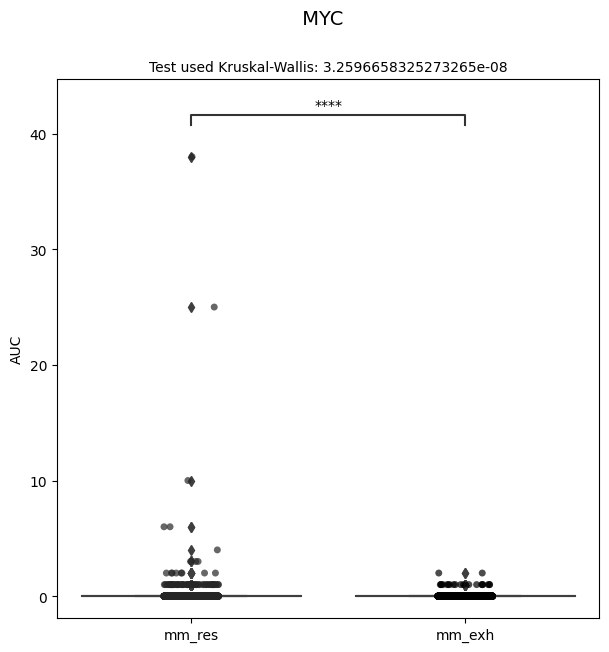








No TF in:ht_res
No TF in:ht_exh
              mm_res        mm_exh
mm_res  1.000000e+00  1.615725e-07
mm_exh  1.615725e-07  1.000000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

mm_res vs. mm_exh: Custom statistical test, P_val:1.616e-07


<AxesSubplot: title={'center': 'Test used Kruskal-Wallis: 1.6157246382445727e-07'}, ylabel='AUC'>

the file name is /BACH2.png


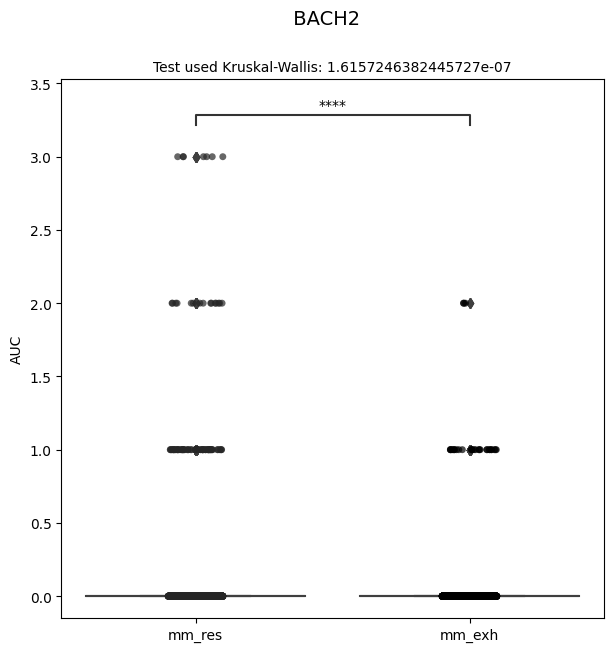








               ht_res        ht_exh        mm_res         mm_exh
ht_res   1.000000e+00  6.403354e-01  5.424008e-68  3.396885e-150
ht_exh   6.403354e-01  1.000000e+00  3.143165e-08   3.029047e-17
mm_res   5.424008e-68  3.143165e-08  1.000000e+00   1.103232e-16
mm_exh  3.396885e-150  3.029047e-17  1.103232e-16   1.000000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ht_exh vs. mm_res: Custom statistical test, P_val:3.143e-08
mm_res vs. mm_exh: Custom statistical test, P_val:1.103e-16
ht_res vs. mm_res: Custom statistical test, P_val:5.424e-68
ht_exh vs. mm_exh: Custom statistical test, P_val:3.029e-17
ht_res vs. mm_exh: Custom statistical test, P_val:3.397e-150


<AxesSubplot: title={'center': 'Test used Kruskal-Wallis: 7.882380114897164e-159'}, ylabel='AUC'>

the file name is /PRDM1.png


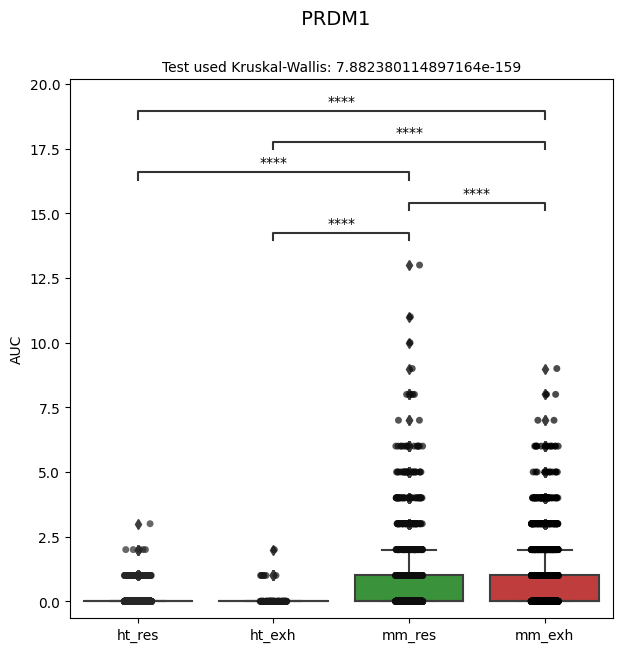








No TF in:ht_res
No TF in:ht_exh
No TF in:mm_res
No TF in:mm_exh
SPI1 not found
No TF in:ht_res
No TF in:ht_exh
No TF in:mm_res
No TF in:mm_exh
SREBF1 not found
              ht_res        ht_exh        mm_res        mm_exh
ht_res  1.000000e+00  1.054613e-01  4.608618e-26  1.016614e-48
ht_exh  1.054613e-01  1.000000e+00  2.508746e-07  6.059753e-11
mm_res  4.608618e-26  2.508746e-07  1.000000e+00  1.565705e-04
mm_exh  1.016614e-48  6.059753e-11  1.565705e-04  1.000000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ht_exh vs. mm_res: Custom statistical test, P_val:2.509e-07
mm_res vs. mm_exh: Custom statistical test, P_val:1.566e-04
ht_res vs. mm_res: Custom statistical test, P_val:4.609e-26
ht_exh vs. mm_exh: Custom statistical test, P_val:6.060e-11
ht_res vs. mm_exh: Custom statistical test, P_val:1.017e-48


<AxesSubplot: title={'center': 'Test used Kruskal-Wallis: 3.984753298327387e-55'}, ylabel='AUC'>

the file name is /STAT4.png


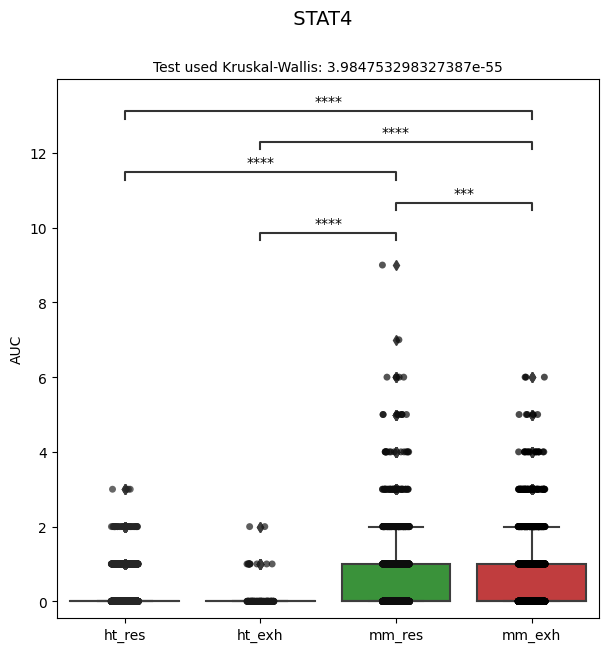








No TF in:ht_res
No TF in:ht_exh
No TF in:mm_res
No TF in:mm_exh
RUNX2 not found
               ht_res        ht_exh        mm_res         mm_exh
ht_res   1.000000e+00  1.269304e-01  1.277385e-65  1.018667e-172
ht_exh   1.269304e-01  1.000000e+00  1.451190e-05   6.706672e-16
mm_res   1.277385e-65  1.451190e-05  1.000000e+00   8.768300e-26
mm_exh  1.018667e-172  6.706672e-16  8.768300e-26   1.000000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ht_exh vs. mm_res: Custom statistical test, P_val:1.451e-05
mm_res vs. mm_exh: Custom statistical test, P_val:8.768e-26
ht_res vs. mm_res: Custom statistical test, P_val:1.277e-65
ht_exh vs. mm_exh: Custom statistical test, P_val:6.707e-16
ht_res vs. mm_exh: Custom statistical test, P_val:1.019e-172


<AxesSubplot: title={'center': 'Test used Kruskal-Wallis: 8.01946300163217e-177'}, ylabel='AUC'>

the file name is /ZEB2.png


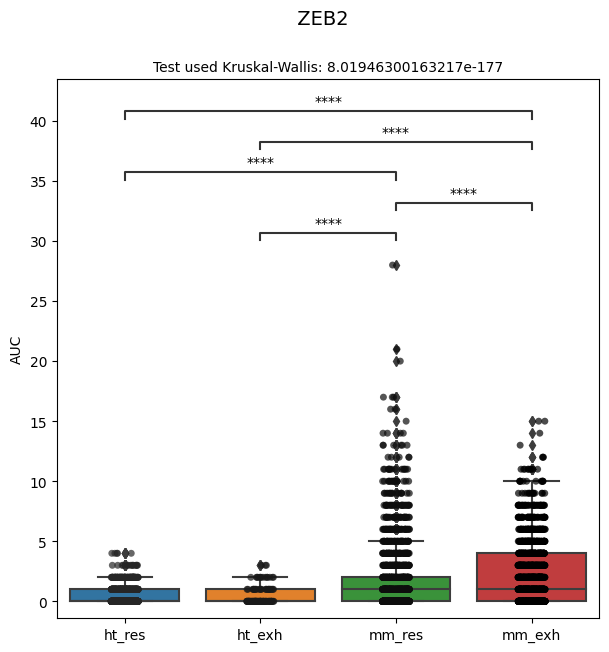








No TF in:ht_res
No TF in:ht_exh
No TF in:mm_res
No TF in:mm_exh
ZBTB32 not found
              ht_res        ht_exh        mm_res        mm_exh
ht_res  1.000000e+00  4.741695e-01  1.506942e-31  9.196643e-93
ht_exh  4.741695e-01  1.000000e+00  1.272147e-03  4.752545e-10
mm_res  1.506942e-31  1.272147e-03  1.000000e+00  6.810657e-17
mm_exh  9.196643e-93  4.752545e-10  6.810657e-17  1.000000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ht_exh vs. mm_res: Custom statistical test, P_val:1.272e-03
mm_res vs. mm_exh: Custom statistical test, P_val:6.811e-17
ht_res vs. mm_res: Custom statistical test, P_val:1.507e-31
ht_exh vs. mm_exh: Custom statistical test, P_val:4.753e-10
ht_res vs. mm_exh: Custom statistical test, P_val:9.197e-93


<AxesSubplot: title={'center': 'Test used Kruskal-Wallis: 9.023066559525411e-94'}, ylabel='AUC'>

the file name is /EOMES.png


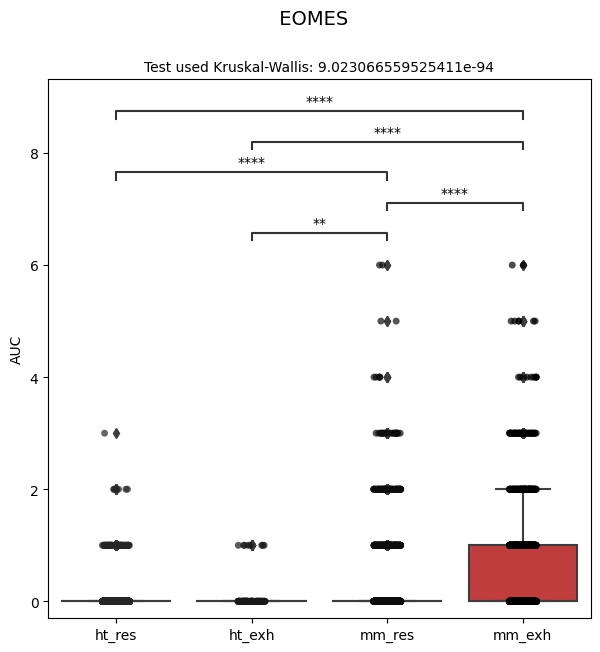








              ht_res    ht_exh        mm_res        mm_exh
ht_res  1.000000e+00  0.714281  2.436109e-26  6.975286e-54
ht_exh  7.142810e-01  1.000000  1.363607e-03  1.943728e-06
mm_res  2.436109e-26  0.001364  1.000000e+00  9.318484e-06
mm_exh  6.975286e-54  0.000002  9.318484e-06  1.000000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ht_exh vs. mm_res: Custom statistical test, P_val:1.364e-03
mm_res vs. mm_exh: Custom statistical test, P_val:9.318e-06
ht_res vs. mm_res: Custom statistical test, P_val:2.436e-26
ht_exh vs. mm_exh: Custom statistical test, P_val:1.944e-06
ht_res vs. mm_exh: Custom statistical test, P_val:6.975e-54


<AxesSubplot: title={'center': 'Test used Kruskal-Wallis: 1.45984925480637e-56'}, ylabel='AUC'>

the file name is /TBX21.png


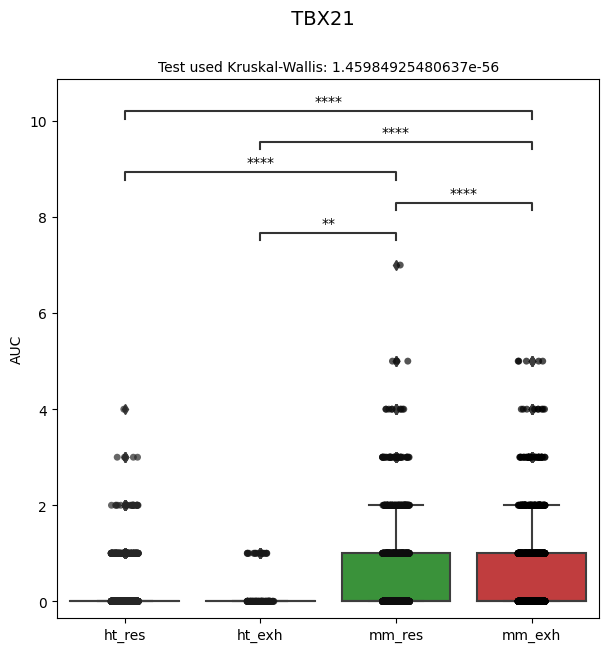








               ht_res        ht_exh        mm_res         mm_exh
ht_res   1.000000e+00  5.134234e-01  4.952728e-72  1.816388e-145
ht_exh   5.134234e-01  1.000000e+00  7.033981e-12   3.826847e-21
mm_res   4.952728e-72  7.033981e-12  1.000000e+00   2.127534e-13
mm_exh  1.816388e-145  3.826847e-21  2.127534e-13   1.000000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ht_exh vs. mm_res: Custom statistical test, P_val:7.034e-12
mm_res vs. mm_exh: Custom statistical test, P_val:2.128e-13
ht_res vs. mm_res: Custom statistical test, P_val:4.953e-72
ht_exh vs. mm_exh: Custom statistical test, P_val:3.827e-21
ht_res vs. mm_exh: Custom statistical test, P_val:1.816e-145


<AxesSubplot: title={'center': 'Test used Kruskal-Wallis: 8.322222708318112e-159'}, ylabel='AUC'>

the file name is /NR3C1.png


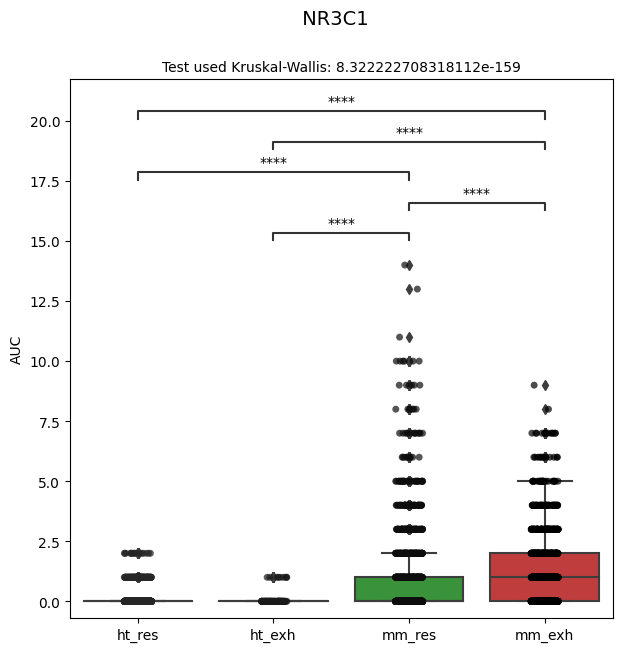

In [94]:

pvalues = pd.DataFrame()
for TF in TFs:
    df = pd.DataFrame()
    
    for key in dfs.keys():
        try:
            auc = dfs[key][TF].reset_index(drop=True)
            df[key] = auc
        except:
            print(f"No TF in:{key}")
    try:
        df, pvalue, adj_pvalues, title, subtitle, test = stats(df, TF)
    except ValueError:
        print(f"{TF} not found")
        continue
    
    file = ""
    filename = ""
    plot(df, adj_pvalues, title, subtitle,file, TF, filename)
    adj_pvalues["TF"] = TF
    adj_pvalues["test"] = test
    if test == "ANOVA":
        adj_pvalues["correction"] = "t-test"
    elif test == "Alexander-Govern":
        adj_pvalues["correction"] = "Welch t-test"
    else:
        adj_pvalues["correction"] = "Dunn"
    pvalues = pvalues.append(adj_pvalues)

In [96]:
pvalues

,mm_res,mm_exh,TF,test,correction,ht_res,ht_exh
mm_res,NaN,3.259666e-08,MYC,Kruskal-Wallis,Dunn,NaN,NaN
mm_exh,NaN,NaN,MYC,Kruskal-Wallis,Dunn,NaN,NaN
mm_res,NaN,1.615725e-07,BACH2,Kruskal-Wallis,Dunn,NaN,NaN
mm_exh,NaN,NaN,BACH2,Kruskal-Wallis,Dunn,NaN,NaN
ht_res,5.424008e-68,3.396885e-150,PRDM1,Kruskal-Wallis,Dunn,NaN,0.640335
ht_exh,3.143165e-08,3.029047e-17,PRDM1,Kruskal-Wallis,Dunn,NaN,NaN
mm_res,NaN,1.103232e-16,PRDM1,Kruskal-Wallis,Dunn,NaN,NaN
mm_exh,NaN,NaN,PRDM1,Kruskal-Wallis,Dunn,NaN,NaN
ht_res,4.608618e-26,1.016614e-48,STAT4,Kruskal-Wallis,Dunn,NaN,0.105461
ht_exh,2.508746e-07,6.059753e-11,STAT4,Kruskal-Wallis,Dunn,NaN,NaN


In [ ]:
df = pd.DataFrame()

for TF in TFs:
    df = df.append(stat("mm_exh","mm_res", TF))

df.sort_values(by="p-value", ascending=False)

,TF,mm_exh,mm_res,p-value,test
0,MYC,1.095238,2.310811,np,Kruskal-Wallis
0,BACH2,1.096774,1.341177,np,Kruskal-Wallis
0,PRDM1,1.900654,2.086539,np,Kruskal-Wallis
0,STAT4,1.528846,1.556114,np,Kruskal-Wallis
0,EOMES,1.477778,1.456193,np,Kruskal-Wallis
0,TBX21,1.384984,1.446985,np,Kruskal-Wallis
0,NR3C1,2.011086,2.375963,**,Kruskal-Wallis
0,ZEB2,3.292345,3.465479,*,Kruskal-Wallis
0,SPI1,missing value,,,
0,SREBF1,missing value,,,


## Differences exhausted resident in healthy:

In [8]:
df = pd.DataFrame()

for TF in TFs:
    df = df.append(stat("ht_exh","ht_res", TF))

df.sort_values(by="p-value", ascending=False)

,TF,ht_exh,ht_res,p-value,test
0,PRDM1,1.125,1.08046,np,Kruskal-Wallis
0,STAT4,1.153846,1.139535,np,Kruskal-Wallis
0,EOMES,1.0,1.121622,np,Kruskal-Wallis
0,TBX21,1.0,1.152838,np,Kruskal-Wallis
0,NR3C1,1.0,1.08,np,Kruskal-Wallis
0,ZEB2,1.47619,1.289827,*,Kruskal-Wallis
0,MYC,missing value,,,
0,BACH2,missing value,,,
0,SPI1,missing value,,,
0,SREBF1,missing value,,,


## Differences exhausted MM vs healthy:

In [9]:
df = pd.DataFrame()

for TF in TFs:
    df = df.append(stat("mm_exh","ht_exh", TF))

df.sort_values(by="p-value", ascending=False)

,TF,mm_exh,ht_exh,p-value,test
0,STAT4,1.528846,1.153846,np,Kruskal-Wallis
0,EOMES,1.477778,1.0,np,Kruskal-Wallis
0,ZEB2,3.292345,1.47619,****,Kruskal-Wallis
0,NR3C1,2.011086,1.0,**,Kruskal-Wallis
0,PRDM1,1.900654,1.125,*,Kruskal-Wallis
0,TBX21,1.384984,1.0,*,Kruskal-Wallis
0,MYC,missing value,,,
0,BACH2,missing value,,,
0,SPI1,missing value,,,
0,SREBF1,missing value,,,


## Differences resident MM vs healthy:

In [10]:
df = pd.DataFrame()

for TF in TFs:
    df = df.append(stat("mm_res","ht_res", TF))

df.sort_values(by="p-value", ascending=False)

,TF,mm_res,ht_res,p-value,test
0,PRDM1,2.086539,1.08046,****,Kruskal-Wallis
0,STAT4,1.556114,1.139535,****,Kruskal-Wallis
0,ZEB2,3.465479,1.289827,****,Kruskal-Wallis
0,TBX21,1.446985,1.152838,****,Kruskal-Wallis
0,NR3C1,2.375963,1.08,****,Kruskal-Wallis
0,EOMES,1.456193,1.121622,***,Kruskal-Wallis
0,MYC,missing value,,,
0,BACH2,missing value,,,
0,SPI1,missing value,,,
0,SREBF1,missing value,,,


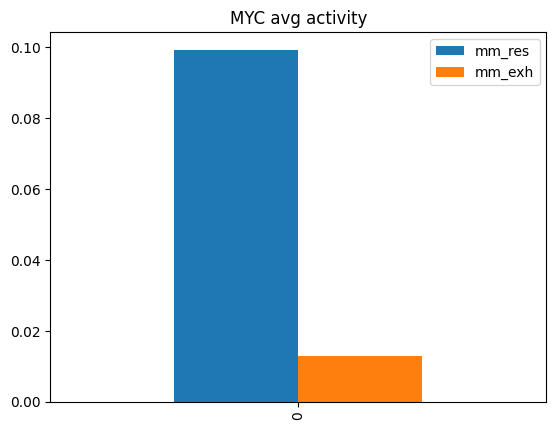

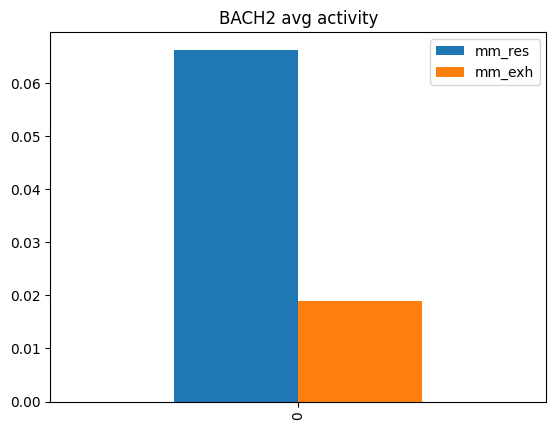

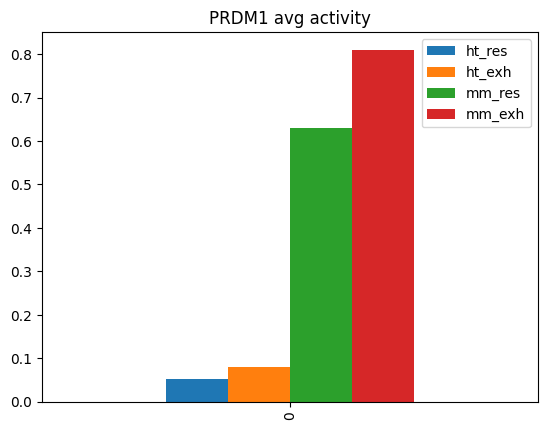

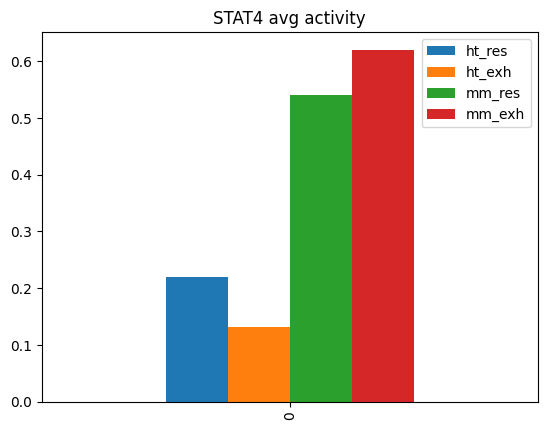

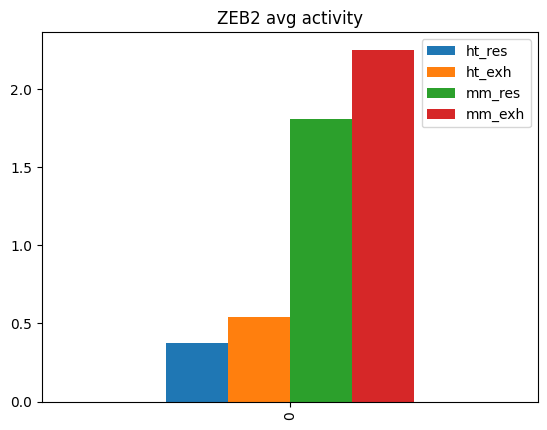

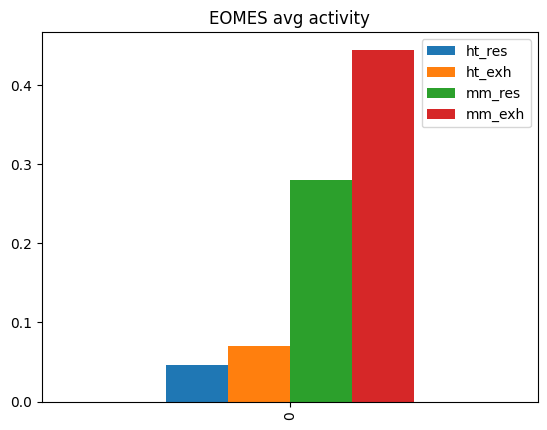

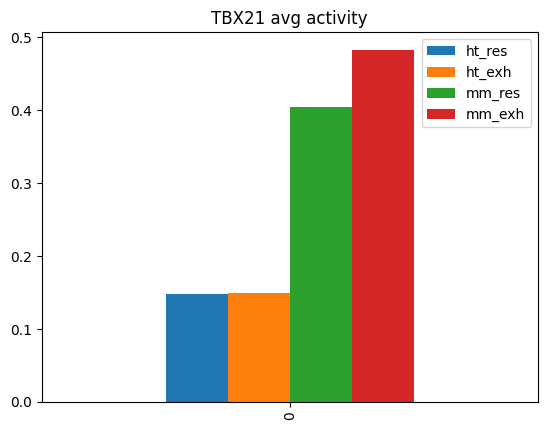

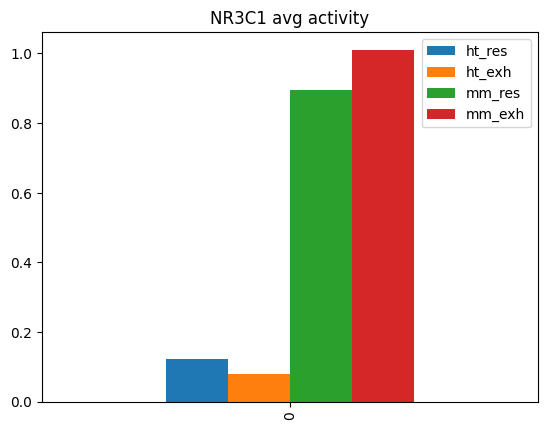

In [11]:
for TF in TFs:
    plot_mean_auc(TF)